## ExtendedData11

Place field analysis – we need to see at least some of the spike plots as the heat maps are too uninformative as to what is going on. The examples in Fig. 5A are great and it would be good to see more like this. We also need some illustration of cluster separation quality. One suggestion is to have one clear example of the main phenomenon where we see the cluster, waveform, and spikeplot so as to gain a really clear picture of what the underlying data look like.


## first we apply it for the remapping figure 

In [1]:
%load_ext autoreload
%autoreload 2

%run ../setup_project.py
%run ../neuronAutopi.py

prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")


data path: /home/pascal/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter
Project name: autopi_ca1
dataPath: /home/pascal/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_ca1
Reading /home/pascal/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects


/home/pascal/repo/Jazi_et.al_2023_noInt/setup_project.py:715: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/pascal/repo/Jazi_et.al_2023_noInt/setup_project.py:743: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/pascal/repo/Jazi_et.al_2023_noInt/setup_project.py:767: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplie

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [01:04<00:00,  1.65s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

You will need about 6Gb of RAM for the next command.

In [3]:
%%time
myProject = loadMyProjectWithTrials(myProject)

Loading: /home/pascal/repo/Jazi_et.al_2023_noInt/data/Jazi_etal_2023_noInter/autopi_ca1/results/myProjectWithTrials.pickle
CPU times: user 10.8 s, sys: 7.13 s, total: 17.9 s
Wall time: 47.8 s


In [4]:
for ses, sSes in tqdm(zip(myProject.sessionList,sSesList)):
    getSearchHomingIntervals(ses,sSes)

39it [00:01, 23.99it/s]


In [5]:
fn=myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

fn=myProject.dataPath+"/results/myMapStats.csv" # , data frame with hd stats
mapStats = pd.read_csv(fn)

fn=myProject.dataPath+"/results/myAutos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myAutos = pickle.load(handle)
    
fn=myProject.dataPath+"/results/mapCorDf.csv"
mapCorDf = pd.read_csv(fn)

fn=myProject.dataPath+"/results/pairs_ifrAsso_mapSim.csv"
pairDf = pd.read_csv(fn)

fn=myProject.dataPath+"/results/pairs_cc.npy"
pairCc = np.load(fn)

fn=myProject.dataPath+"/results/mySearchHomingMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    SHmyMaps = pickle.load(handle)

fn=myProject.dataPath+"/results/mySearchHomingMapStats.csv" # , data frame with hd stats
SHmapStats = pd.read_csv(fn)

fn=myProject.dataPath+"/results/searchHomingMapCorDf.csv"
print("Loading",fn)
SHmapCorDf = pd.read_csv(fn)

fn=myProject.dataPath+"/results/searchHomingPairs_ifrAsso_mapSim.csv"
print("Loading",fn)
SHpairDf = pd.read_csv(fn)




Loading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/searchHomingMapCorDf.csv
Loading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/searchHomingPairs_ifrAsso_mapSim.csv


Only keep pyramidal cells

In [6]:
fn=myProject.dataPath+"/results/cell_classification_noint.csv"
ct = pd.read_csv(fn)


In [7]:
if ct.shape[0]!=myMaps["circ80"].shape[0]:
    print("problem with length of cell_classification.csv")

pyrIndices=ct.cellType== "pyr"
pyrId=ct.id[ct.cellType== "pyr"]
print("Pyramidal cells: {}".format(np.sum(ct.cellType=="pyr")))


Pyramidal cells: 438


In [8]:
for key in myMaps:
    myMaps[key]=myMaps[key][pyrIndices]
for key in myAutos:
    myAutos[key]["auto"]=myAutos[key]["auto"][pyrIndices]
for key in SHmyMaps:
    SHmyMaps[key]=SHmyMaps[key][pyrIndices]
    
    
mapStats = mapStats[mapStats.cellId.isin(pyrId)]

nCond = len(mapCorDf.condition.unique())
mapCorDf["cellId"] = np.concatenate([ct.id.to_numpy()]*nCond) # 4 because of 4 conditions
mapCorDf = mapCorDf[mapCorDf.cellId.isin(pyrId)]

pairPyrIndices = np.logical_and(np.isin(pairDf.id1,pyrId),np.isin(pairDf.id2,pyrId)) # id1 and id2 in the pair are pyr
pairDf = pairDf[pairPyrIndices]
pairCc = pairCc[pairPyrIndices]

pairPyrIndices = np.logical_and(np.isin(SHpairDf.id1,pyrId),np.isin(SHpairDf.id2,pyrId)) # id1 and id2 in the pair are pyr


In [9]:
pyrId = pyrId.reset_index(drop=True)
pyrId.shape
pyrId


0       mn5824-20112020-0107_92
1      mn5824-20112020-0107_100
2      mn5824-20112020-0107_114
3      mn5824-20112020-0107_116
4      mn5824-20112020-0107_118
                 ...           
433     mn9686-01112021-0106_79
434     mn9686-01112021-0106_81
435    mn9686-01112021-0106_197
436    mn9686-01112021-0106_242
437    mn9686-01112021-0106_246
Name: id, Length: 438, dtype: object

## Define the fucs we will use later 

In [10]:

def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY)
    ax.axis('off')
    
def get_sSesId_nId(cellId):
    
    sesName= cellId.split('_')[0]
    cellName= cellId.split('_')[1]
    sesid= [sSes.name for sSes in sSesList].index(sesName)
    sSes= sSesList[sesid]
    ses= myProject.sessionList[sesid]
    nid= [n.name for n in sSes.cg.neuron_list].index(cellName)
    n= sSes.cg.neuron_list[nid]
    return sSes,ses,n

def spike_on_the_path(ses, sSes,n, cond):
    
    inter= ses.intervalDict[cond]
    
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)
    
    sSes.ap.unset_intervals()
    sSes.ap.set_intervals(inter)
    sSes.ap.invalid_outside_spatial_area(environment_shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    n.set_spatial_properties(sSes.ap)
    spike_posi= n.spatial_properties.spike_position()

    return spike_posi

def get_task_Rand_map(ses, sSes, n, cond):

    xy_range=np.array([[-50,-90],[50,60]])
    inter= ses.intervalDict[cond]
    n.spike_train.unset_intervals()
    n.spike_train.set_intervals(inter)

    sSes.ap.set_intervals(inter)
    sSes.ap.invalid_outside_spatial_area(environment_shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)
    CellMap= n.spatial_properties.firing_rate_map
    
    return CellMap

#####################################
## get the mean waveform on the shank
#####################################

def get_mwf_onshank(sSes, ses, n):
        
    sSes.cg.set_info_from_session(sSes, 1)## 
    ch= n.channels ## channel with the hieghest amp
    shanks_arr, active_shanks, electrodes = sSes.get_active_shanks(ch)
    shank= int(active_shanks[0])
    print(shanks_arr)

    ### get ch number on the shank
    chOnshank=np.where(sSes.channel_positions[:,0]==shank)[0]
    return chOnshank

################################
############# wf related func
#################################

def get_wfAndylimForHighamp(chOnshank,n, sSes):
    
    for i,ch in enumerate(chOnshank):
        if ch == n.channels:
            #print(n.cluster_number, ch)
            c,w= sSes.get_waveform_from_cluster(n.cluster_number, ch)
            #print(w)
            neww= w[w!=0]
            #print(len(neww))
            ylim= np.min(neww),np.max(neww)
    return neww, ylim 

def getwf_plot(ax,cellId, plotScale=True):
    """
    Plot the waveforms on 8 channels from 1 neuron
    The channels are on a given shanks
    """
    
    yOffset=0.2
    xOffset=0.0022
    ncol=2
    spikeWidth=40
    samplingRate=20000
    
    sSes, ses, n= get_sSesId_nId(cellId)
    chOnshank= get_mwf_onshank (sSes, ses, n)
    
    # two variables for the origin of the scale bar
    minYValue=0
    minXValue=-0.0001
    for i,ch in enumerate(chOnshank):
        
        xOff = i%ncol*xOffset
        yOff = np.floor(i/ncol)*yOffset
        
        c,w= sSes.get_waveform_from_cluster(n.cluster_number, ch)
                
        # focus on the middle 40 datapoints 
        
        start= int(w.shape[0]/2-spikeWidth/2)
        end = int(start+spikeWidth)
        time = np.arange(spikeWidth)/samplingRate
        
        currentMin = np.min(w[start:end]+yOff)
        if currentMin < minYValue:
            minYValue = currentMin
        
        ax.plot(time+xOff, w[start:end]+yOff, lw=1.5)
        
    
    # The scale bar for time is 0.001 sec, or 1 ms.
    ax.plot([minXValue,minXValue + 0.001],[minYValue-0.01,minYValue-0.01],color="black",lw=2)
    # I don't know what the units are for the y axis. The vertical scale is 0.1 in length
    ax.plot([minXValue,minXValue],[minYValue,minYValue+0.1],color="black",lw=2)
    
    ax.axis('off')
                


[False, False, False, True]


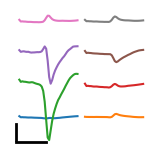

In [11]:
cellId= 'mn5824-20112020-0107_92'

nCells=1
col=1
row=1
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gs = fig.add_gridspec(nrows=row, ncols=col) # one gridspec including all the figure
ax= fig.add_subplot(gs[0])
getwf_plot(ax,cellId)

In [12]:
def plotRFAutoPIMaps(cellId, gs):
    
    conditions =['circ80', 'task']
    conditionNames = ["RF", "AutoPI"]
    ind= pyrId[pyrId==cellId].index.item()
    sSes,ses,n= get_sSesId_nId(cellId)

    gsMaps= gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs[0],width_ratios=[1, 1,0.2,1,1])
    gsTitles= gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs[0],width_ratios=[2,0.2,2])
    
    
    for j,(cond, cname) in enumerate(zip(conditions,conditionNames)):
        
        ax= fig.add_subplot(gsTitles[0+j*2])
        ax.set_title(cname,y= 1,fontsize=10 )
        ax.axis('off')
        ############################
        ## plot the spikes on the path
        ###########################
        ax= fig.add_subplot(gsMaps[0+j*3])
        spike_posi= spike_on_the_path(ses, sSes,n, cond)
        #ax.set_aspect('equal', adjustable='box')
        plt.plot(sSes.ap.pose[:,1],sSes.ap.pose[:,2], c='gray', alpha=0.5,linewidth=1.5)
        plt.scatter(spike_posi[:,0], spike_posi[:,1], s= 0.05, c='red')
        ax.set_aspect('equal')
        
        ax.axis('off')

        ##############################
        ### plot the firing rate map
        ###############################

        ax= fig.add_subplot(gsMaps[1+j*3])
        ax.set_aspect('equal', adjustable='box')
        CellMap= get_task_Rand_map(ses, sSes, n, cond)
        plt.imshow(CellMap.T[13:-3,:] ,origin="lower",cmap='jet',interpolation=None)
        title="{:.2f} Hz".format(np.nanmax(CellMap))
        ax.set_title(title,y= 0.95,fontsize=10 )
        ax.axis('off')


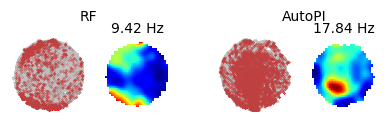

In [13]:
sizePerRow, sizePerCol = 1.2, 1.2 #figurePanelDefaultSize()
cellId= 'mn711-01022021-0107_117'
col=4
row=1
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gs = fig.add_gridspec(nrows=1, ncols=1) # one gridspec including all the figure
plotRFAutoPIMaps(cellId, gs)

In [14]:
def plot_RandTask_plots(cellId, gs,plotWaveformScale=True):
    # function to plot waveforms, spike-time autocorrelation and spatial data (spike-on-path and firing rate maps during random foraging and the AutoPI task)
    # Argument: cellId and a 1x1 gridspec 
    # You should give the 1x1 gridspec a dimension that fits 1 row and 6 columns

    gsTrials= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],width_ratios=[0.8,1.4,1.2,4],wspace=0.2)
    #gsTrials= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],width_ratios=[0.8, 1.2,1.5,4])
    
    ind= pyrId[pyrId==cellId].index.item()
    sSes,ses,n= get_sSesId_nId(cellId)

    #########################
    ### get the waveform
    #########################
    ax= fig.add_subplot(gsTrials[0])  
    getwf_plot(ax,cellId,plotWaveformScale)


    #########################
    ### get the spiketime auto
    #########################
    gsAuto= gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gsTrials[1], width_ratios=[0.01, 0.98,0.01],height_ratios=[0.1,0.8,0.1])
    ax= fig.add_subplot(gsAuto[1,1])  
    plt.plot(myAutos[25]["time"]*1000,myAutos[25]["auto"][ind])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel('Spike count')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_tick_params(labelsize= 9)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    ###########################
    # plot the firing rate maps
    ###########################
    gsMaps= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsTrials[3])
    plotRFAutoPIMaps(cellId, gsMaps)

[True, False, False, False, False, False, False, False]


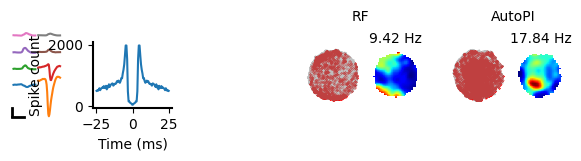

In [15]:
    

sizePerRow, sizePerCol = 1.2, 1.2 #figurePanelDefaultSize()
#cellId= 'mn711-01022021-0107_117'
col=6
row=1
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gs = fig.add_gridspec(nrows=1, ncols=1) # one gridspec including all the figure
plot_RandTask_plots(cellId, gs)

In [16]:
def plotOneNeuron(cellId,gs):
    
    gsCellIntro= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])
    #gsMapTrials= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1])
    plot_RandTask_plots(cellId, gsCellIntro)
    #plotAutoPIMapsTrialTypes(cellId, gsMapTrials)

In [17]:
cellIds= ['mn5824-20112020-0107_92', 'mn5824-24112020-0107_110', 'mn711-31012021-0107_45', 'mn711-01022021-0107_117' ]


[False, False, False, True]


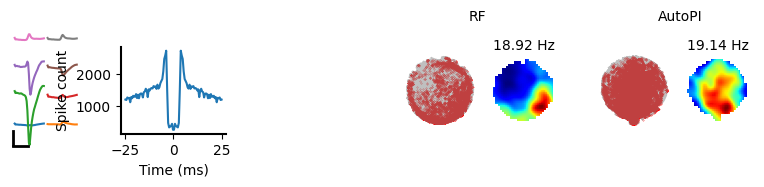

In [18]:
sizePerRow, sizePerCol = 1.6, 1.6 #figurePanelDefaultSize()
cellId= cellIds[0]
row=1
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gs = fig.add_gridspec(nrows=1, ncols=1)
plotOneNeuron(cellId,gs)

## Add the LDA for the cluster plot 


In [19]:
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# cross validation
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### nonlinear models 
from sklearn import svm


In [20]:

def cluOnshank(cellId):
    
    sSes,ses,n= get_sSesId_nId(cellId)
    sSes.cg.set_info_from_session(sSes,1) ## clus from the active shank
    shanks_arr, active_shanks, electrodes= sSes.get_active_shanks(n.channels)
    shank=active_shanks[0]
    
    cluOnshk=[]
    for i,n in enumerate(sSes.cg.neuron_list):
        shanks_arr, active_shanks, electrodes= sSes.get_active_shanks(n.channels)
        if shank in active_shanks:
            cluOnshk.append(n.cluster_number)
    
    return cluOnshk

def get_IsolationDistance(cellId,cluOnshk):
    
    sSes,ses,n= get_sSesId_nId(cellId)
    pcf= np.load(sSes.path+'/pc_features.npy') ## [nSpikes, nFeaturesPerChannel, nPCFeatures] single
    spikeclu=np.load(sSes.path+"/spike_clusters.npy")
    ################################
    ### get the ind for the n of interest 
    ###################################
    
    ind1= (spikeclu== n.cluster_number) ### index of the spikes for this clu
    pcf_clu1= pcf[ind1]
    
    ################################################
    ##################################################
    ## get the features of the spikes for the first n
    ## reshape to get all fet from all channels
    ##################################################
    ###################################################
    
    pcfClu1= pcf_clu1.reshape((pcf_clu1.shape[0],pcf_clu1.shape[1]*pcf_clu1.shape[2]))
    MeanClu1= np.mean(pcfClu1, axis = 0)
    Covclu1= np.cov(pcfClu1.T)

    MedianD=[]
    distances=[]
    pcf_clus=[] ## pc features for all spikes for all clusters
    Id_clus=[] ## cluster number for corresponding pc features
    
    for clu in cluOnshk:

        ind= (spikeclu== clu) ### index of the spikes for this clu
        pcf_clu= pcf[ind]
        pcfClu= pcf_clu.reshape((pcf_clu.shape[0],pcf_clu.shape[1]*pcf_clu.shape[2])) ## pc features for eah spikes of that clu
        pcf_clus.append(pcfClu)
        Id_clus.append([clu]*len(pcfClu))
        
        res= np.array([distance.mahalanobis(u,MeanClu1,Covclu1) for u in pcfClu])
        distances.append(np.transpose([res,[clu]*len(res)]))
        MedianD.append(np.median(res))
        #print(np.median(res),clu)
        
    distances= np.concatenate(distances)
    MedianDneuron= np.median(distances[distances[:,1]==n.cluster_number,0])
    pcf_clus= np.concatenate(pcf_clus)
    Id_clus=np.concatenate(Id_clus)
    distances_sorted = np.array(sorted(distances,key=lambda x:x[0]))
    
    ind= distances_sorted[:,1]==n.cluster_number
    
    ########################
    #### calculate the isolation score
    ######################
    
    ratio= np.cumsum(ind)/np.arange(len(ind))
    indRatio= ratio< 0.5
    IsolationScore=np.nan
    if np.any(indRatio):
        r=np.arange(len(indRatio))
        indRatio_belowthreshold= np.where([np.all(indRatio[r_:]) for r_ in r])[0]
        if len(indRatio_belowthreshold):
            IsolationScore= distances_sorted[indRatio_belowthreshold[0],0]
    
    return MedianDneuron, np.array(MedianD), distances, distances_sorted, IsolationScore, pcf_clus, Id_clus




In [21]:
#################
## Run the LDA to classify clusters
##################
def RunLDA_onclusters(cellId, cluOnshk):
    
    sSes,ses,n= get_sSesId_nId(cellId)
    MedianDneuron ,MedianD, distances, distances_sorted, IsolationScore, pcf_clus,Id_clus = get_IsolationDistance(cellId,cluOnshk)
    estimator = LinearDiscriminantAnalysis()
    estimator.fit(pcf_clus, Id_clus)
    cluster_assignment = (Id_clus==n.cluster_number).astype(int)

    estimator = LinearDiscriminantAnalysis()
    estimator.fit(pcf_clus, cluster_assignment)
    accuracy= estimator.score(pcf_clus, cluster_assignment)
    prediction= estimator.decision_function(pcf_clus)
    histbins=np.arange(min(prediction),max(prediction),.5)
    print(min(prediction),max(prediction))
    
    return prediction,accuracy, histbins, cluster_assignment

def plot_LDA(gs, cellId,cluOnshk):

    gsLDA= gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[0])
    #gsLDA= gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs)
    prediction,accuracy, histbins, cluster_assignment= RunLDA_onclusters(cellId,cluOnshk)
    #print(histbins)
    
    ax= fig.add_subplot(gsLDA[0])
    y1, x1, _ = plt.hist(prediction[cluster_assignment==1], histtype=u'step',bins= histbins, density=True, label='C.')
    y2, x2, _ = plt.hist(prediction[cluster_assignment==0], histtype=u'step', bins= histbins,density=True, label='O.')
    ax.set_xlim(np.mean(prediction)- 6* np.std(prediction), np.mean(prediction)+ 10* np.std(prediction)) ### (-5*,7*)
    #ax.set_ylim(min(y1), np.mean(y1)+ 25* np.std(y1))## 25 for the mn5824_110
    ax.set_ylim(0,np.max(y2))
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8))
    #ax.axvline(x=0, c='g')
    ax.set_xlabel('Predicted classification value')
    ax.set_ylabel('Spikes density')
    #ax.set_title('Cluster seperation using LDA')
    ax.text(0.6,0.50,'Acc.: {:.2}'.format(accuracy),transform=ax.transAxes)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    #ax.show()
    

In [22]:
def plot_RandTask_plots(cellId, gs,plotWaveformScale=True):
    
    ###############################################################
    # function to plot waveforms, spike-time autocorrelation and spatial data (spike-on-path and firing rate maps during random foraging and the AutoPI task)
    # Argument: cellId and a 1x1 gridspec 
    # You should give the 1x1 gridspec a dimension that fits 1 row and 6 columns
    ###############################################################################
    
    
    gsTrials= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],width_ratios=[1,1.2,2,4],wspace=0.2, hspace=0.5)
    #gsTrials= gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],width_ratios=[0.8, 1.2,1.2,4])
    
    ind= pyrId[pyrId==cellId].index.item()
    sSes,ses,n= get_sSesId_nId(cellId)

    #########################
    ### get the waveform
    #########################
    ax= fig.add_subplot(gsTrials[0])  
    getwf_plot(ax,cellId,plotWaveformScale)


    #########################
    ### get the spiketime auto
    #########################
    gsAuto= gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gsTrials[1], width_ratios=[0.01, 0.98,0.01],height_ratios=[0.1,0.8,0.1]) ## add space around it 
    ax= fig.add_subplot(gsAuto[1,1])  
    plt.plot(myAutos[25]["time"]*1000,myAutos[25]["auto"][ind])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_ylabel('Spike count')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_tick_params(labelsize= 9)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    ###########################
    ## Plot the LDA
    ###########################
    #gscell= gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gsTrials[2],width_ratios=[0.01, 0.98,0.01])
    gscell= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsTrials[2])
    cluOnshk= cluOnshank(cellId)
    plot_LDA(gscell, cellId,cluOnshk)
    #plot_LDA(gscell[1], cellId,cluOnshk)
    
    ###########################
    # plot the firing rate maps
    ###########################
    gsMaps= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsTrials[3])
    plotRFAutoPIMaps(cellId, gsMaps)

In [23]:
def plotOneNeuron(cellId,gs):
    
    gsCellIntro= gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])
    plot_RandTask_plots(cellId, gsCellIntro)


In [24]:
### example cells for fig3.a
cellIds=["mn9686-27102021-0106_27","mn9686-29102021-0106_41"
,"mn9686-29102021-0106_253","mn9686-01112021-0106_64"
"mn1173-09052021-0108_95","mn711-02022021-0108_133"]

-37.753273 61.94888


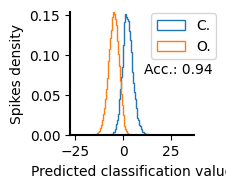

In [25]:
col=1
row=1

sizePerRow, sizePerCol = 1.6, 1.6
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(nrows=1, ncols=1) # one gridspec including all the figure

cellId=cellIds[4]
cluOnshk= cluOnshank(cellId)
gscell= gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[0], hspace=0.3)
plot_LDA(gscell, cellId,cluOnshk)


plt.show()


[False, True, False, False, False, False, False, False]
-37.753273 61.94888


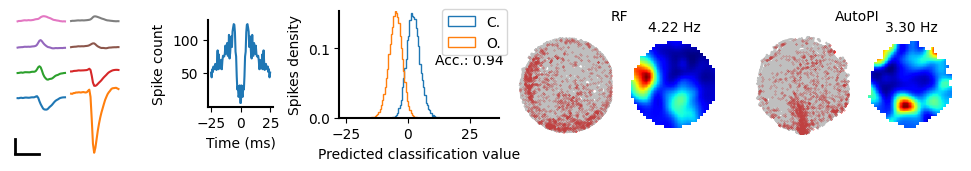

In [26]:
sizePerRow, sizePerCol = 1.6, 1.6 #figurePanelDefaultSize()
cellId= cellIds[4]
col=6
row=1
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = fig.add_gridspec(nrows=1, ncols=1)
plotOneNeuron(cellId,gs)

In [27]:
## example cells for figure 5. 
cellIds=["mn9686-28102021-0107_178","mn9686-29102021-0106_230", "mn9686-28102021-0107_31", "mn711-01022021-0107_75"]

## example cells for figure6 and figure 7 
cellIds=["mn3246-09042021-0106_102", "mn3246-10042021-0106_236", "mn1173-11052021-0108_57", "mn711-31012021-0107_47"]

In [28]:
## example cells for fig3.e
cellIds=["mn9686-27102021-0106_55", "mn5824-24112020-0107_110","mn2739-17022021-0106_15","mn9686-01112021-0106_6",
"mn2739-17022021-0106_99","mn9686-27102021-0106_56"]

In [29]:
## Example cells for figure 3.b 
cellIds=["mn9686-27102021-0106_27","mn9686-29102021-0106_41","mn9686-29102021-0106_253",
         "mn9686-01112021-0106_64","mn1173-09052021-0108_95","mn711-02022021-0108_133"]

In [ ]:
#cellIds=["mn9686-27102021-0106_27","mn711-02022021-0108_133"] ## figure 5
sizePerRow, sizePerCol = 1.6,1.8 ## 1.6,2
nCell= len(cellIds)
col=6
row=nCell
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(nrows=nCell, ncols=1,figure=fig) # one gridspec including all the figure ## fig should be called 

for i,cellId in enumerate(cellIds):
    gsrow= gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[i])
    plotOneNeuron(cellId,gsrow)



[False, True, False, False, False, False, False, False]
-82.73459 70.02597
[False, True, False, False, False, False, False, False]
-151.32088 83.83283


### Generate the same thing but for fig 4

In [ ]:
cellIds=["mn3246-10042021-0106_296","mn1173-06052021-0107_26","mn3246-10042021-0106_244","mn1173-06052021-0107_116",
        "mn3246-12042021-0106_49","TYY5622-17092021-0106_41","mn1173-06052021-0107_99","mn711-31012021-0107_44"]

In [ ]:
#cellIds=["mn9686-27102021-0106_27","mn711-02022021-0108_133"] # figure6
sizePerRow, sizePerCol = 1.6,1.8 ## 1.6,2
nCell= len(cellIds)
col=6
row=nCell
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) # create the overall figure to put all the axes on
gs = gridspec.GridSpec(nrows=nCell, ncols=1,figure=fig) # one gridspec including all the figure ## fig should be called 

for i,cellId in enumerate(cellIds):
    gsrow= gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[i])
    plotOneNeuron(cellId,gsrow)

